## Importing Required packages

In [210]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [ ]:
!git clone https://github.com/dphi-official/Datasets.git

Cloning into 'Datasets'...
remote: Enumerating objects: 10001, done.
remote: Total 10001 (delta 0), reused 0 (delta 0), pack-reused 10001
Receiving objects: 100% (10001/10001), 439.23 MiB | 20.82 MiB/s, done.
Resolving deltas: 100% (145/145), done.
Checking out files: 100% (9367/9367), done.


In [180]:
train = pd.read_csv('/content/Datasets/patient_treat_class/training_set_label.csv')
test = pd.read_csv('/content/Datasets/patient_treat_class/testing_set_label.csv')
train.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,33.8,11.1,4.18,4.6,150,26.6,32.8,80.9,33,F,1
1,44.6,14.0,6.86,6.3,232,20.4,31.4,65.0,36,M,0
2,42.9,14.0,4.57,6.2,336,30.6,32.6,93.9,70,F,0
3,41.9,14.4,4.67,3.5,276,30.8,34.4,89.7,18,F,0
4,40.6,13.3,4.85,14.9,711,27.4,32.8,83.7,36,M,0


## EDA

In [181]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HAEMATOCRIT   3309 non-null   float64
 1   HAEMOGLOBINS  3309 non-null   float64
 2   ERYTHROCYTE   3309 non-null   float64
 3   LEUCOCYTE     3309 non-null   float64
 4   THROMBOCYTE   3309 non-null   int64  
 5   MCH           3309 non-null   float64
 6   MCHC          3309 non-null   float64
 7   MCV           3309 non-null   float64
 8   AGE           3309 non-null   int64  
 9   SEX           3309 non-null   object 
 10  SOURCE        3309 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 284.5+ KB


In [ ]:
train['SEX'] = train['SEX'].replace({'M':1,'F':0})
test['SEX'] = test['SEX'].replace({'M':1,'F':0})
train.head()

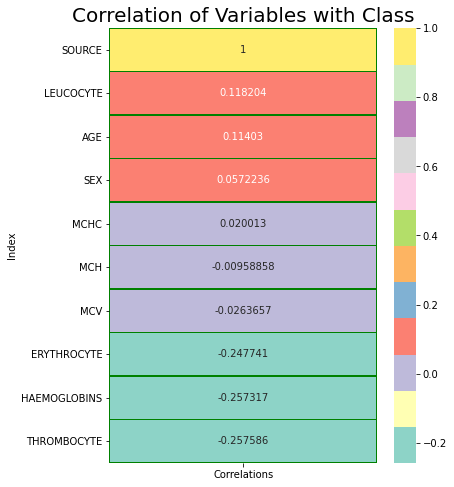

In [190]:
corr = train.corrwith(train['SOURCE'],method='spearman').reset_index()

corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False).head(10)

plt.figure(figsize=(6, 8))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='Set3', linewidths=0.4, linecolor='green')

plt.title("Correlation of Variables with Class", fontsize=20)
plt.show()

In [185]:
col = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'MCH', 'MCHC', 'MCV', 'AGE', 'SEX']
X = train[col]
y = train['SOURCE']

Counter({0: 1992, 1: 1317})


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


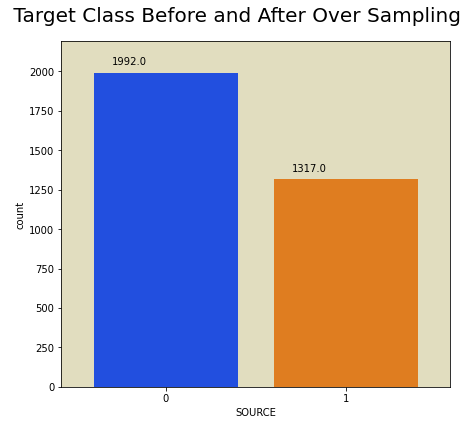

In [196]:
print(Counter(train['SOURCE']))
fig, ax = plt.subplots(1, 1,figsize=(6,6))
fig.subplots_adjust(bottom=0.10, left=0.10, top = 0.900, right=1.00)
fig.suptitle(' Target Class Before and After Over Sampling', fontsize = 20)
sns.set_palette("bright")
sns.countplot(train['SOURCE'], ax=ax)
ax.margins(0.1)
ax.set_facecolor("#e1ddbf")
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
sns.set_palette("bright")

In [ ]:
Counter(train['SOURCE'])

Counter({0: 1992, 1: 1317})

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42,stratify=y,shuffle=True)

## LogisticRegression

In [207]:
class_weight={0:1,1:1.5125284738041003}
lr = LogisticRegression(class_weight=class_weight,random_state=42)
lr.fit(X_train,y_train)
lr_predicted = lr.predict(X_test)
lr_acc_score = f1_score(y_test, lr_predicted)
lr_predicted_t =  f1_score(y_train,lr.predict(X_train))
print("F1 score of Logistic Regression test:",lr_acc_score*100)
print("F1 score of  Logistic Regression train:",lr_predicted_t*100)

F1 score of Logistic Regression test: 64.41176470588235
F1 score of  Logistic Regression train: 64.47497546614326


## RandomForestClassifier

In [208]:
rf = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=3,class_weight=class_weight)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_acc_score = f1_score(y_test, rf_predicted)
rf_predicted_t =  f1_score(y_train,rf.predict(X_train))
print("F1 score of Random Forest test:",rf_acc_score*100)
print("F1 score of Random Forest train:",rf_predicted_t*100)


F1 score of Random Forest test: 62.17948717948717
F1 score of Random Forest train: 65.7417289220918


## LGBMClassifier

In [216]:
class_weight={0:1,1:1.5125284738041003}
cat_col = ['SEX']
lgb = LGBMClassifier(n_estimators=500,depth=3,learning_rate=0.01,objective='binary',metric='f1',is_unbalance=True,class_weight=class_weight,
                 colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,random_state=42,n_jobs=-1)
lgb.fit(X_train,y_train,eval_metric='auc',eval_set=(X , y),verbose=False,categorical_feature=cat_col,early_stopping_rounds= 100)
lgb_predicted = lgb.predict(X_test)
lgb_predicted_t =  f1_score(y_train,lgb.predict(X_train))
lgb_acc_score = f1_score(y_test, lgb_predicted)
print("F1 score of Light Gradient Boost-test:",lgb_acc_score*100)
print("F1 score of Light Gradient Boost-train:",lgb_predicted_t*100)

[LightGBM] [Warning] Unknown parameter: depth
F1 score of Light Gradient Boost-test: 67.53623188405797
F1 score of Light Gradient Boost-train: 82.68968650613357


## Ensembling : VotingClassifier

In [217]:
classifier=[('LGBM',lgb),('LR',lr),('rf',rf)]
vc=VotingClassifier(estimators=classifier,voting='soft')
vc.fit(X_train,y_train)
vc_predicted = vc.predict(X_test)
vc_predicted_t =  f1_score(y_train,vc.predict(X_train))
vc_acc_score = f1_score(y_test, vc_predicted)
print("F1 score of Light Gradient Boost-test:",vc_acc_score*100)
print("F1 score of Light Gradient Boost-train:",vc_predicted_t*100)

[LightGBM] [Warning] Unknown parameter: depth
F1 score of Light Gradient Boost-test: 66.96969696969697
F1 score of Light Gradient Boost-train: 74.46393762183234


In [218]:
lr = lr.fit(X,y)
rf = rf.fit(X,y)
vc = vc.fit(X,y)

[LightGBM] [Warning] Unknown parameter: depth


## Final Blending

In [220]:
pred_lgb = lgb.predict_proba(test)[:,1]
pred_rf = rf.predict_proba(test)[:,1]
pred_vc = vc.predict_proba(test)[:,1]
w1 = 0.25
w2 = 0.25
w3 = 0.5
final = (w1*pred_lgb) + (w2*pred_rf) + (w3*pred_vc)
test['SOURCE'] = [0 if i<0.4 else 1  for i in final]

In [221]:
submit = pd.DataFrame(test['SOURCE']) 
submit.index = test.index 
submit.columns = ["prediction"]

In [222]:
from google.colab import files
submit.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>